In [2]:
import numpy as np
import gym
import math
import random
import time
from IPython.display import clear_output

In [3]:
env = gym.make("FrozenLake-v1")

In [4]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

q_table = np.zeros((state_space_size, action_space_size))
print(q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [74]:
num_episodes = 10000
max_steps_per_episode = 200
learning_rate = 0.01
discount_rate = 0.99
exploration_rate = 1
max_exploration_rate = 0.9
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

In [48]:
rewards_all_episodes = []
for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards_current_episode = 0
    for step in range(max_steps_per_episode):
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate or (episode > 0.95*num_episodes):
            action = np.argmax(q_table[state, :])
        else:
            action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        q_table[state, action] = q_table[state, action] * (1-learning_rate) + \
        learning_rate * (reward + discount_rate*np.max(q_table[new_state, :]))
        state = new_state
        rewards_current_episode += reward
        if done == True:
            break
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate-min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
    rewards_all_episodes.append(rewards_current_episode)

reward_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes/1000)
count = 1000
print("**********Avg reward per Thousand episodes*********\n")
for r in reward_per_thousand_episodes:
    print(count, ":", str(sum(r/1000)))
    count += 1000

print("\n\n**********Q-Table********\n")
print(q_table)

**********Avg reward per Thousand episodes*********

1000 : 0.05200000000000004
2000 : 0.23100000000000018
3000 : 0.4250000000000003
4000 : 0.5950000000000004
5000 : 0.6470000000000005
6000 : 0.6560000000000005
7000 : 0.7230000000000005
8000 : 0.6910000000000005
9000 : 0.6710000000000005
10000 : 0.7030000000000005


**********Q-Table********

[[0.53507174 0.52153743 0.52444913 0.52044134]
 [0.3666331  0.32522613 0.29940434 0.49908149]
 [0.4344527  0.42905933 0.42210992 0.46518149]
 [0.29015785 0.28293119 0.30922928 0.45109458]
 [0.54936358 0.3816377  0.35858924 0.35329567]
 [0.         0.         0.         0.        ]
 [0.27612652 0.17146185 0.33488953 0.13818694]
 [0.         0.         0.         0.        ]
 [0.38715219 0.41422622 0.40740309 0.57696675]
 [0.43225704 0.62412936 0.43356916 0.41039823]
 [0.5877404  0.49954319 0.43239861 0.35856919]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.43104325 0.59986028 0.7392189  0.4843347

In [49]:
for episode in range(15):
    state = env.reset()
    done = False
    print("*****EPISODE", episode+1, "*********\n")
    time.sleep(1)
    
    for step in range(max_steps_per_episode):
        clear_output(wait=True)
        env.render()
        time.sleep(0.3)
        action = np.argmax(q_table[state, :])
        new_state, reward, done, info = env.step(action)
        
        if done:
            clear_output(wait=True)
            env.render()
            if reward == 1:
                print("******* You reached the goal.")
            else:
                print("**** You fell through a hole!****")
                time.sleep(3)
            clear_output(wait=True)
            break
        state = new_state
env.close()


KeyboardInterrupt: 

In [42]:
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [43]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [44]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [45]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

In [46]:
e = Experience(2, 3, 1, 4)
e

Experience(state=2, action=3, next_state=1, reward=4)

In [47]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) *\
            math.exp(-1 * current_step * self.decay)

In [48]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device)

In [49]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make("CartPole-v1").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen =screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40, 90)),
            T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device)

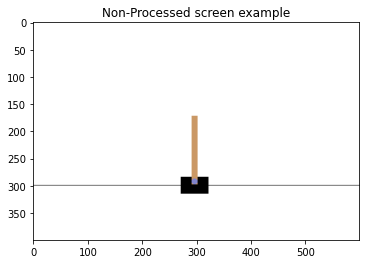

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')
plt.figure()
plt.imshow(screen)
plt.title('Non-Processed screen example')
plt.show()

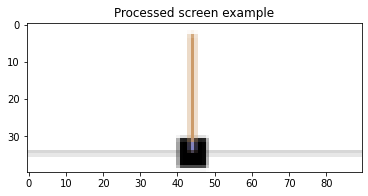

In [51]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
plt.title('Processed screen example')
plt.show()

In [52]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count += 1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [59]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1)\
        .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    screen = em.render('rgb_array')
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(values)
    plt.plot(moving_avg)
    plt.pause(0.001)
#     plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
    plt.imshow(screen)
    print("Episode", len(values), "\n", \
         moving_avg_period, "episode moving avg:",
         moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

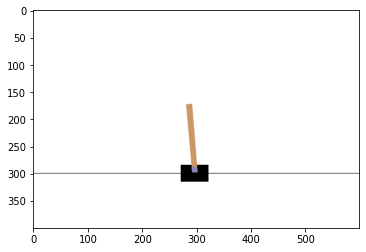

In [60]:
plot(np.random.rand(300), 100)

In [61]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [62]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

In [63]:
class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values
     

In [67]:
import warnings
warnings.filterwarnings('ignore')

KeyboardInterrupt: 

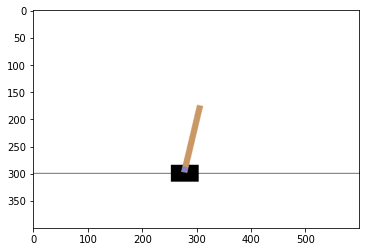

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_current(target_net, states, actions)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()